# Pasos de este jupyter

- `Paso 0: Gestión de valores nulos`: Antes de cualquier transformación, es fundamental que revise y trate los valores nulos para asegurar la calidad del análisis. En este paso:

    - Gestionare los valores nulos en cualquiera de estas columnas, ya que son esenciales para el análisis de cesta.

- `Paso 1: Filtrado por país`: Dado que algunos países tienen muy poca actividad, puedo:

    - Trabajar exclusivamente con un país principal (por ejemplo, United Kingdom) para asegurar volumen y calidad de reglas.

    - O bien, conservar solo los países con un número mínimo de transacciones, y excluir los de bajo volumen para evitar ruido.


- `Paso 2: Transformación a formato “basket”`: Convertir el dataset de formato transaccional (varias filas por factura) a una **matriz de facturas vs. productos**, donde cada celda representa la cantidad total de un producto en una transacción.


- `Paso 3: Binarización`: Para aplicar modelos como Apriori, necesito una matriz binaria. Por tanto, convertiré la presencia de productos en cada transacción a 1 (presente) o 0 (ausente), sin importar la cantidad.


- `Paso 4: Filtrado de productos poco frecuentes`: Para reducir ruido y mejorar la eficiencia del modelo, es recomendable eliminar los productos que aparecen en muy pocas facturas. Esto ayudará a centrar el análisis en productos relevantes y frecuentes.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)


In [2]:
# cargamos el conjunto de datos
df = pd.read_csv('../data/retail_limpio.csv', low_memory=False, index_col = 0)
df.head()

Invoice StockCode                  Description  Quantity  \
131147  501854         M                       MANUAL         3   
103829  499297       NaN          WAY OUT METAL SIGN        288   
513051  537225         M                       MANUAL         1   
109914  499965         M                       MANUAL         6   
461607  533027       NaN  PACK OF 12 SPACEBOY TISSUES       111   

                InvoiceDate  Price  Customer ID         Country  Month  Year  \
131147  2010-03-21 11:15:00    1.0      15446.0  United Kingdom      3  2010   
103829  2010-02-25 20:16:00    1.0      18102.0  United Kingdom      2  2010   
513051  2010-12-05 16:41:00    1.0      12748.0  United Kingdom     12  2010   
109914  2010-03-03 13:57:00    1.0      16461.0  United Kingdom      3  2010   
461607  2010-11-15 16:02:00    1.0          NaN  United Kingdom     11  2010   

        TotalPrice  
131147         3.0  
103829       288.0  
513051         1.0  
109914         6.0  
461607       111.0

# Gestion de valores nulos

Recordemos que se identificaron valores nulos en las siguientes columnas:

- `StockCode`: 352.035 valores nulos  
- `Customer ID`: 94.618 valores nulos

**¿Qué podemos hacer con los valores nulos?**

- `StockCode`: Esta columna puede ser útil si queremos completar información faltante en otras variables, como `Description`. En este caso puedo:

    - Ver si estos valores nulos en `StockCode` coinciden con descripciones existentes o si son registros que no aportan valor.
    
    - Si los valores nulos en `StockCode` no pueden ser recuperados ni utilizados, eliminaré esos registros.

- `Customer ID`: Aunque puede ser útil para análisis de comportamiento por cliente, **no es necesaria para construir la matriz de productos por transacción**. Además, la gran cantidad de valores ausentes hace que su imputación no sea fiable en este contexto. En este caso: 

    - Se ignorarán los valores nulos en esta columna, ya que no interfiere con el preprocesamiento necesario para el *basket analysis*.

# Filtrado por pais

Dado que algunos países tienen muy poca actividad en el conjunto de datos, es importante tomar decisiones que garanticen la calidad del análisis y de las reglas que se generen. En este proyecto, planteo dos enfoques complementarios:

- **Opción 1: Trabajar exclusivamente con un país principal**, concretamente `United Kingdom`, ya que representa la mayor parte de las transacciones. Esto asegura volumen suficiente para generar reglas frecuentes estables y representativas. Es una forma de reducir ruido y centrarse en un comportamiento de compra bien definido.

- **Opción 2: Conservar solo los países con un mínimo de transacciones**. En este caso, se establecerá un umbral de actividad (por ejemplo, número mínimo de facturas) y se filtrarán aquellos países con baja participación. Esto permite incluir otros mercados relevantes sin sobrecargar el análisis con registros marginales que pueden distorsionar los resultados.

Dado que ambos enfoques tienen ventajas y limitaciones distintas, se aplicarán por separado y se compararán los resultados obtenidos en la fase de modelado. Esto permitirá identificar cuál de las dos estrategias produce reglas de asociación más relevantes y útiles.

In [3]:
# creo el dataframe con los datos de UK
df_uk = df[df["Country"] == 'United Kingdom' ]
df_uk.head()

Invoice StockCode                  Description  Quantity  \
131147  501854         M                       MANUAL         3   
103829  499297       NaN          WAY OUT METAL SIGN        288   
513051  537225         M                       MANUAL         1   
109914  499965         M                       MANUAL         6   
461607  533027       NaN  PACK OF 12 SPACEBOY TISSUES       111   

                InvoiceDate  Price  Customer ID         Country  Month  Year  \
131147  2010-03-21 11:15:00    1.0      15446.0  United Kingdom      3  2010   
103829  2010-02-25 20:16:00    1.0      18102.0  United Kingdom      2  2010   
513051  2010-12-05 16:41:00    1.0      12748.0  United Kingdom     12  2010   
109914  2010-03-03 13:57:00    1.0      16461.0  United Kingdom      3  2010   
461607  2010-11-15 16:02:00    1.0          NaN  United Kingdom     11  2010   

        TotalPrice  
131147         3.0  
103829       288.0  
513051         1.0  
109914         6.0  
461607       111.0

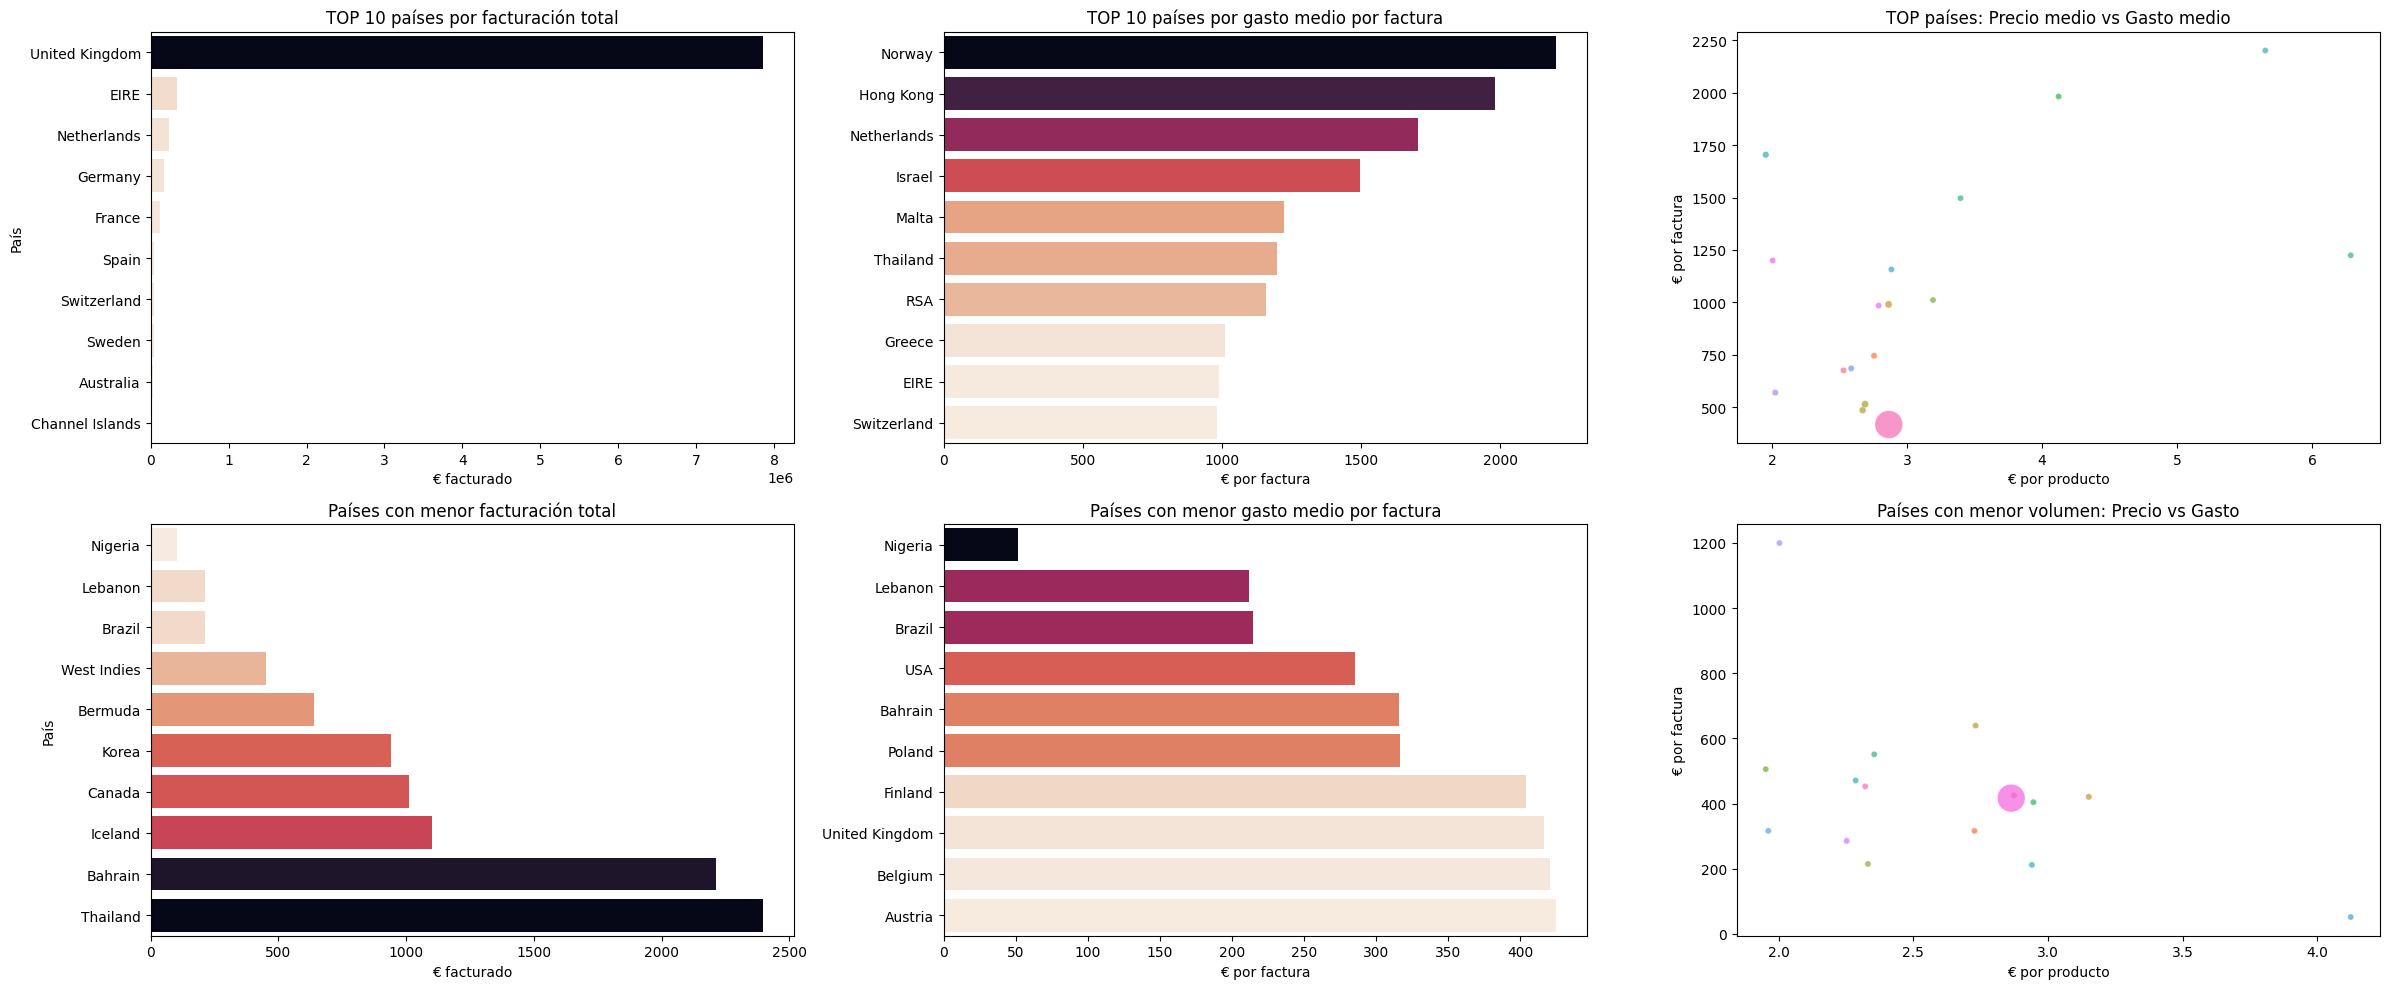

In [4]:
# veamos que hacer con la opcon 2. Teniendo en cuenta que estos eran nuestros principales resultados

# creo todas las agrupaciones para mi objetivo
df_por_pais = df.groupby("Country").agg(
    N_facturas=("Invoice", "nunique"),
    N_productos=("Quantity", "sum"),
    Total_facturado=("TotalPrice", "sum")
).reset_index()

# calculo el precio medio por producto
df_por_pais["Precio_medio_producto"] = df_por_pais["Total_facturado"] / df_por_pais["N_productos"]

# calculo el precio medio por transaccion
df_por_pais["Gasto_medio_factura"] = df_por_pais["Total_facturado"] / df_por_pais["N_facturas"]

top_facturacion = df_por_pais.sort_values("Total_facturado", ascending=False).head(10)
top_gasto_medio = df_por_pais.sort_values("Gasto_medio_factura", ascending=False).head(10)

bottom_facturacion = df_por_pais.sort_values("Total_facturado", ascending=True).head(10)
bottom_gasto_medio = df_por_pais.sort_values("Gasto_medio_factura", ascending=True).head(10)


# Crear figura con 2x3 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 10))

# --- TOP PAISES ---
sns.barplot(y="Country", 
            x="Total_facturado", 
            data=top_facturacion, 
            palette="rocket_r", 
            hue = "Total_facturado", 
            legend = False,
            ax=axes[0, 0])

axes[0, 0].set_title("TOP 10 países por facturación total")
axes[0, 0].set_xlabel("€ facturado")
axes[0, 0].set_ylabel("País")

sns.barplot(y="Country", 
            x="Gasto_medio_factura", 
            data=top_gasto_medio, 
            palette="rocket_r", 
            hue = "Gasto_medio_factura", 
            legend = False,
            ax=axes[0, 1])

axes[0, 1].set_title("TOP 10 países por gasto medio por factura")
axes[0, 1].set_xlabel("€ por factura")
axes[0, 1].set_ylabel("")

sns.scatterplot(
    x="Precio_medio_producto", 
    y="Gasto_medio_factura", 
    data=df_por_pais[df_por_pais["Country"].isin(top_facturacion["Country"]) | 
                     df_por_pais["Country"].isin(top_gasto_medio["Country"])],
    size="N_facturas", 
    hue="Country",
    sizes=(20, 400),
    alpha=0.7,
    ax=axes[0, 2],
    legend=False
)
axes[0, 2].set_title("TOP países: Precio medio vs Gasto medio")
axes[0, 2].set_xlabel("€ por producto")
axes[0, 2].set_ylabel("€ por factura")

# --- BOTTOM PAISES ---
sns.barplot(y="Country", 
            x="Total_facturado", 
            data=bottom_facturacion, 
            palette="rocket_r", 
            hue = "Total_facturado", 
            legend = False,
            ax=axes[1, 0])


axes[1, 0].set_title("Países con menor facturación total")
axes[1, 0].set_xlabel("€ facturado")
axes[1, 0].set_ylabel("País")

sns.barplot(y="Country", 
            x="Gasto_medio_factura", 
            data=bottom_gasto_medio, 
            palette="rocket", 
            hue = "Gasto_medio_factura", 
            legend = False,
            ax=axes[1, 1])

axes[1, 1].set_title("Países con menor gasto medio por factura")
axes[1, 1].set_xlabel("€ por factura")
axes[1, 1].set_ylabel("")

sns.scatterplot(
    x="Precio_medio_producto", 
    y="Gasto_medio_factura", 
    data=df_por_pais[df_por_pais["Country"].isin(bottom_facturacion["Country"]) | 
                     df_por_pais["Country"].isin(bottom_gasto_medio["Country"])],
    size="N_facturas", 
    hue="Country",
    sizes=(20, 400),
    alpha=0.7,
    ax=axes[1, 2],
    legend=False
)
axes[1, 2].set_title("Países con menor volumen: Precio vs Gasto")
axes[1, 2].set_xlabel("€ por producto")
axes[1, 2].set_ylabel("€ por factura")

# Ajustar todo el layout
plt.tight_layout()
plt.show()

Dado que existe una gran concentración de volumen en `United Kingdom`, y que otros países muestran comportamientos de compra distintos (por ejemplo, tickets más altos aunque con menos frecuencia), planteó el siguiente criterio de inclusión:

- **Conservar únicamente los países con al menos 100 transacciones**, lo que garantizara una mínima representatividad en el dataset.

- Adicionalmente, se podrían conservar países con menor volumen pero con indicadores destacados, como un gasto medio por factura elevado.

Este enfoque me permitirá equilibrar el modelo incluyendo mercados relevantes sin introducir ruido procedente de países marginales, que han demostrado tener poca actividad en el análisis exploratorio.



In [5]:
paises_seleccionados = [
    'United Kingdom', 'Germany', 'France', 'Spain', 'Switzerland', 'EIRE',
    'Norway', 'Hong Kong', 'Netherlands', 'Israel', 'Malta', 'Thailand'
]
df_transacciones = df[df["Country"].isin(paises_seleccionados)]
df_transacciones.head()

Invoice StockCode                  Description  Quantity  \
131147  501854         M                       MANUAL         3   
103829  499297       NaN          WAY OUT METAL SIGN        288   
513051  537225         M                       MANUAL         1   
109914  499965         M                       MANUAL         6   
461607  533027       NaN  PACK OF 12 SPACEBOY TISSUES       111   

                InvoiceDate  Price  Customer ID         Country  Month  Year  \
131147  2010-03-21 11:15:00    1.0      15446.0  United Kingdom      3  2010   
103829  2010-02-25 20:16:00    1.0      18102.0  United Kingdom      2  2010   
513051  2010-12-05 16:41:00    1.0      12748.0  United Kingdom     12  2010   
109914  2010-03-03 13:57:00    1.0      16461.0  United Kingdom      3  2010   
461607  2010-11-15 16:02:00    1.0          NaN  United Kingdom     11  2010   

        TotalPrice  
131147         3.0  
103829       288.0  
513051         1.0  
109914         6.0  
461607       111.0

# Transformación a formato “basket”

En este paso convertire la estructura del conjunto de datos para que se adapte a lo que necesitan los algoritmos de reglas de asociación.

El formato original del dataset es **transaccional**, lo que significa que cada fila representa un producto comprado en una factura concreta. Es decir, una misma factura puede aparecer en varias filas si incluye varios productos.

Lo que busco ahora es transformar esa información en una **matriz de facturas por productos** (también conocida como formato “basket”), donde:

- Cada **fila representa una factura** (o transacción).

- Cada **columna representa un producto**.

- Y el **valor de cada celda** indica si ese producto fue comprado en esa factura (por ejemplo, cuántas unidades se compraron).

Esta estructura permite ver, de un vistazo, **qué productos se compraron juntos** en una misma transacción. Es la base sobre la cual los algoritmos identificarán patrones de co-ocurrencia, como por ejemplo: “quien compra el producto A, también suele comprar el producto B”. Es similar a tener una tabla donde cada fila es una cesta de la compra y cada columna marca los productos presentes en ella.

In [16]:
# lo primero que tengo que hacer es agrupar los productos por factura para los dos conjuntos de datos
df_basket_uk = df_uk.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack()
df_basket_transacciones = df_transacciones.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack()

# cuando un producto no aparece en una cesta aparecerá como NaN, por lo que voy a reeamplzarlo por 0
df_basket_uk = df_basket_uk.fillna(0)
df_basket_transacciones = df_basket_transacciones.fillna(0)
df_basket_uk.sample(5)

Description    DOORMAT UNION JACK GUNS AND ROSES   3 STRIPEY MICE FELTCRAFT  \
Invoice                                                                       
518253                                       0.0                        0.0   
521547                                       0.0                        0.0   
508045                                       0.0                        0.0   
491238                                       0.0                        0.0   
515346                                       0.0                        0.0   

Description   4 PURPLE FLOCK DINNER CANDLES   BANK CHARGES  \
Invoice                                                      
518253                                  0.0            0.0   
521547                                  0.0            0.0   
508045                                  0.0            0.0   
491238                                  0.0            0.0   
515346                                  0.0            0.0   

Description   BLACK PIRATE TREASURE CHEST   BROWN  PIRATE TREASURE CHEST   \
Invoice                                                                     
518253                                0.0                             0.0   
521547                                0.0                             0.0   
508045                                0.0                             0.0   
491238                                0.0                             0.0   
515346                                0.0                             0.0   

Description   CAMPHOR WOOD PORTOBELLO MUSHROOM  \
Invoice                                          
518253                                     0.0   
521547                                     0.0   
508045                                     0.0   
491238                                     0.0   
515346                                     0.0   

Description   CHERRY BLOSSOM  DECORATIVE FLASK   FAIRY CAKE CANDLES  \
Invoice                                                               
518253                                     0.0                  0.0   
521547                                     0.0                  0.0   
508045                                     0.0                  0.0   
491238                                     0.0                  0.0   
515346                                     0.0                  0.0   

Description   FLAMINGO LIGHTS   HOME SWEET HOME  BLACKBOARD  \
Invoice                                                       
518253                    0.0                           0.0   
521547                    0.0                           0.0   
508045                    0.0                           0.0   
491238                    0.0                           0.0   
515346                    0.0                           0.0   

Description   IVORY PAPER CUP CAKE CASES    LARGE SKULL WINDMILL  \
Invoice                                                            
518253                                0.0                    0.0   
521547                                0.0                    0.0   
508045                                0.0                    0.0   
491238                                0.0                    0.0   
515346                                0.0                    0.0   

Description   NEW BAROQUE BLACK BOXES   OVAL WALL MIRROR DIAMANTE   \
Invoice                                                              
518253                            0.0                          0.0   
521547                            0.0                          0.0   
508045                            0.0                          0.0   
491238                            0.0                          0.0   
515346                            0.0                          0.0   

Description   PAINT YOUR OWN CANVAS SET   PEACE WOODEN BLOCK LETTERS  \
Invoice                                                                
518253                              0.0                          0.0

# Binarización

Una vez transformado el dataset al formato "basket" (una matriz donde las filas son transacciones y las columnas son productos), el siguiente paso es convertir esa matriz en una versión **binaria**, es decir, que contenga únicamente **1s y 0s**. Esto es importante porque los algoritmos clásicos de reglas de asociación, como **Apriori** o **FP-Growth**, no analizan cuántas unidades de un producto se compraron, sino simplemente si el producto estuvo presente o no en una transacción. En esta binarización:

- Se asigna un **1** si el producto aparece en la factura, independientemente de la cantidad comprada.

- Se asigna un **0** si el producto no aparece en esa transacción.

Este enfoque simplifica el análisis y permite centrarse en las **combinaciones frecuentes de productos**, que es el objetivo principal del *basket analysis*.

In [17]:
df_basket_uk = df_basket_uk.map(lambda x: 1 if x > 0 else 0)
df_basket_transacciones = df_basket_transacciones.map(lambda x: 1 if x > 0 else 0)
df_basket_uk.sample(5)

Description    DOORMAT UNION JACK GUNS AND ROSES   3 STRIPEY MICE FELTCRAFT  \
Invoice                                                                       
531550                                         0                          0   
534109                                         0                          0   
536508                                         0                          0   
498756                                         0                          0   
504868                                         0                          0   

Description   4 PURPLE FLOCK DINNER CANDLES   BANK CHARGES  \
Invoice                                                      
531550                                    0              0   
534109                                    0              0   
536508                                    0              0   
498756                                    0              0   
504868                                    0              0   

Description   BLACK PIRATE TREASURE CHEST   BROWN  PIRATE TREASURE CHEST   \
Invoice                                                                     
531550                                  0                               0   
534109                                  0                               0   
536508                                  0                               0   
498756                                  0                               0   
504868                                  0                               0   

Description   CAMPHOR WOOD PORTOBELLO MUSHROOM  \
Invoice                                          
531550                                       0   
534109                                       0   
536508                                       0   
498756                                       0   
504868                                       0   

Description   CHERRY BLOSSOM  DECORATIVE FLASK   FAIRY CAKE CANDLES  \
Invoice                                                               
531550                                       0                    0   
534109                                       0                    0   
536508                                       0                    0   
498756                                       0                    0   
504868                                       0                    0   

Description   FLAMINGO LIGHTS   HOME SWEET HOME  BLACKBOARD  \
Invoice                                                       
531550                      0                             0   
534109                      0                             0   
536508                      0                             0   
498756                      0                             0   
504868                      0                             0   

Description   IVORY PAPER CUP CAKE CASES    LARGE SKULL WINDMILL  \
Invoice                                                            
531550                                  0                      0   
534109                                  0                      0   
536508                                  0                      0   
498756                                  0                      0   
504868                                  0                      0   

Description   NEW BAROQUE BLACK BOXES   OVAL WALL MIRROR DIAMANTE   \
Invoice                                                              
531550                              0                            0   
534109                              0                            0   
536508                              0                            0   
498756                              0                            0   
504868                              0                            0   

Description   PAINT YOUR OWN CANVAS SET   PEACE WOODEN BLOCK LETTERS  \
Invoice                                                                
531550                                0                            0

In [18]:
df_basket_uk.to_csv("../data/retail_uk_transformado.csv")
df_basket_transacciones.to_csv("../data/retail_transacciones_transformado.csv")